Created: 2020.07.20

Modified: 2020.07.31

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import random
import pandas as pd
from pathlib import Path

import sys
sys.path.append('functions')
import functions32 as f32

# 2D CORONAL - T1_biascorr

In [3]:
folder_path = Path('/data-10tb/shared/skull/coronal-2d/')

df = pd.read_csv(folder_path/'bias_mask-test-val-coronal-2d.csv')
print(df.shape)
df.head(3)

(602715, 6)


,root,bias_path,image_full_path,mask_full_path,usage_txt,usage
0,/data-10tb/shared/skull/coronal-2d,/train/ADNI/ADNI_003_S_0931_MR_MPR-R__GradWarp...,/data-10tb/shared/skull/coronal-2d/train/ADNI/...,/data-10tb/shared/skull/coronal-2d/train/ADNI/...,train,False
1,/data-10tb/shared/skull/coronal-2d,/train/ADNI/ADNI_003_S_0931_MR_MPR-R__GradWarp...,/data-10tb/shared/skull/coronal-2d/train/ADNI/...,/data-10tb/shared/skull/coronal-2d/train/ADNI/...,train,False
2,/data-10tb/shared/skull/coronal-2d,/train/ADNI/ADNI_003_S_0931_MR_MPR-R__GradWarp...,/data-10tb/shared/skull/coronal-2d/train/ADNI/...,/data-10tb/shared/skull/coronal-2d/train/ADNI/...,train,False


#### Create DataBunch

In [4]:
# item list
il = SegmentationItemList.from_df(df, folder_path, cols='bias_path', convert_mode='L')

In [5]:
# split data
sd = il.split_from_df(col='usage')

In [7]:
codes = np.loadtxt(folder_path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [9]:
# label list
ll = sd.label_from_df(cols='mask_full_path', classes=codes)

In [10]:
tmfs2 = get_transforms(do_flip=True, flip_vert=False,
                      max_rotate=15, max_zoom=1.05,
                      max_lighting=0.2, max_warp=None,
                      p_affine=0.5, p_lighting=0.5
                      )
bs=128
size = 128

In [11]:
ll = ll.transform(tmfs2, tfm_y=True, size=size, padding_mode='zeros', resize_method=ResizeMethod.PAD)

In [12]:
data = ll.databunch(bs=bs).normalize(imagenet_stats)

In [13]:
data.train_ds[0]

(Image (1, 128, 128), ImageSegment (1, 128, 128))

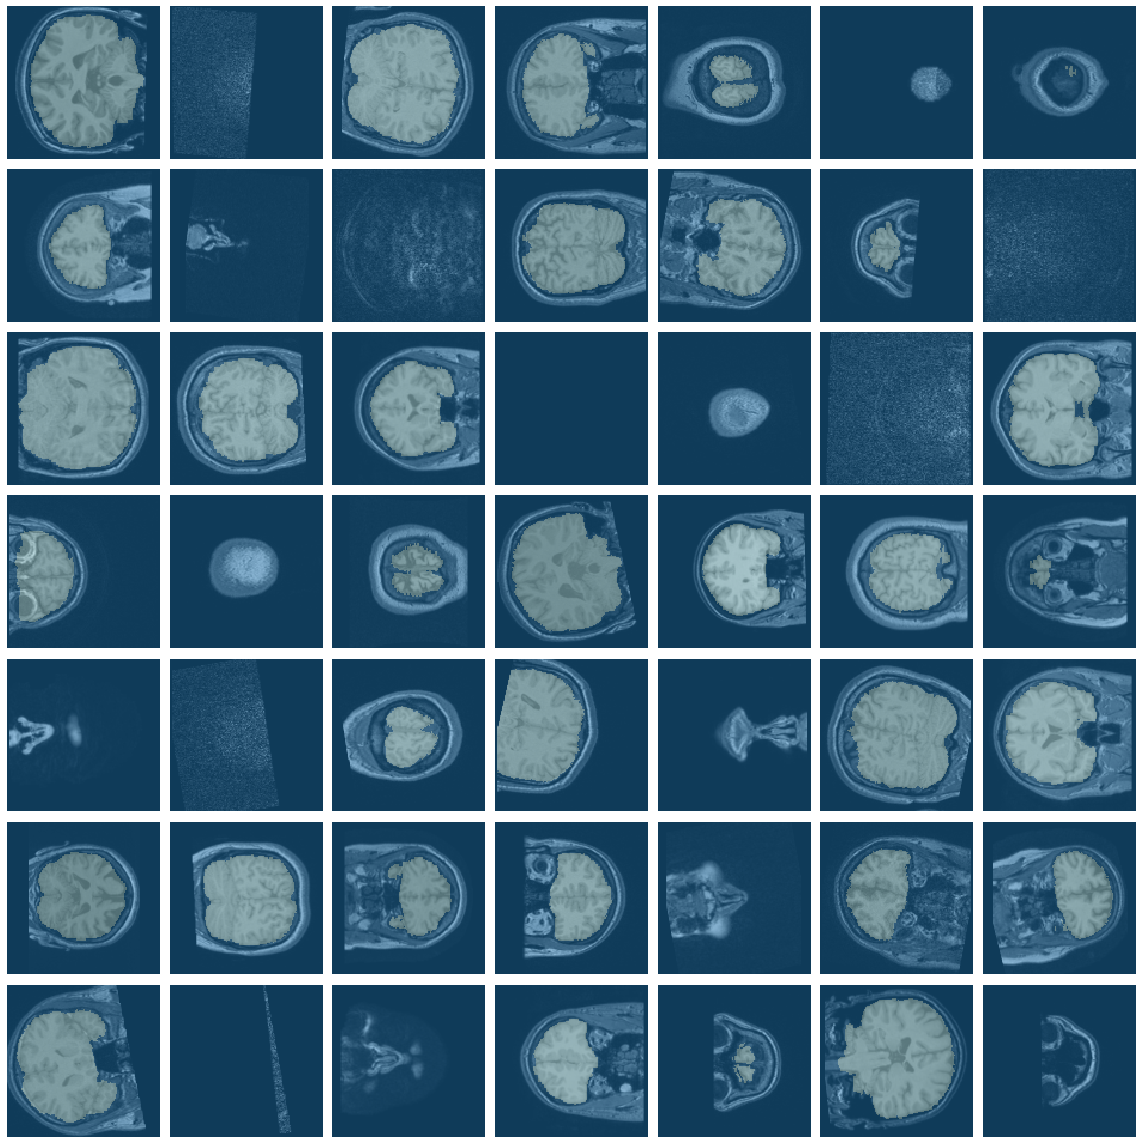

In [14]:
data.show_batch(7, figsize=(16,16))

In [13]:
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=16
# else:           bs=8
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [15]:
wd=1e-2

In [16]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 2.51E-04


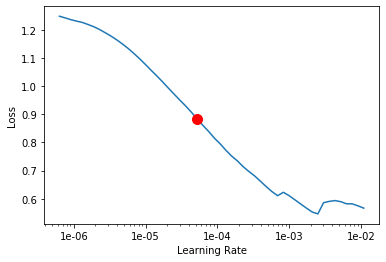

In [18]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

### LR=1e-4

In [20]:
lr=1e-4

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.030661,0.028613,0.947115,1:12:09
1,0.025594,0.027433,0.950496,34:44
2,0.021563,0.025623,0.954867,34:55
3,0.019612,0.026479,0.954339,35:14
4,0.018588,0.026105,0.955270,36:33


In [22]:
# #id-trening-axial/freeze-unfreeze/fit-one-cycle-5/lr=1e-5/split-data
save = 0

sname = '3.03_01_train-coronal_bias_fr_foc-05_lr-4_sp-all'
if save:
    learn.save(sname)

In [23]:
learn.load(sname);

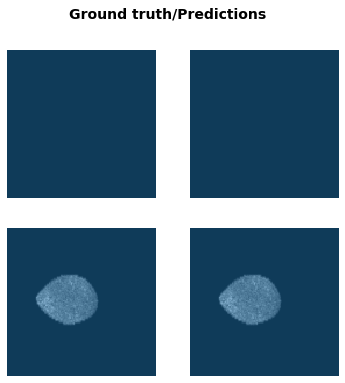

In [24]:
learn.show_results(rows=2, figsize=(6,6))

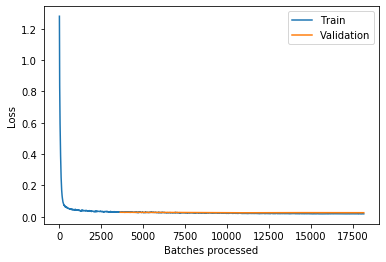

In [25]:
learn.recorder.plot_losses()

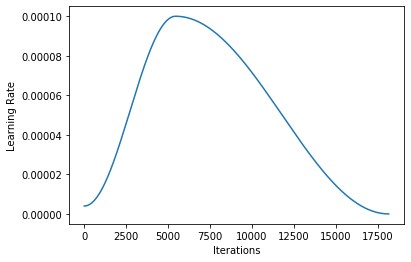

In [26]:
learn.recorder.plot_lr()

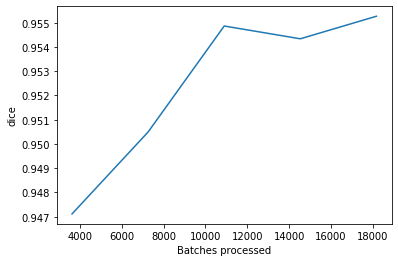

In [27]:
learn.recorder.plot_metrics()

In [28]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.020476,0.024789,0.955172,44:26
1,0.019756,0.026500,0.955005,36:42
2,0.019342,0.025707,0.954482,44:14
3,0.017281,0.027627,0.956629,38:51
4,0.016847,0.027211,0.956494,43:18


In [23]:
# save = 0

# sname = '3.03_02_train-coronal_bias_fr_foc-10_lr-1e4_sp-all'
# if save:
#     learn.save(sname)

In [29]:
#learn.fit_one_cycle(5, slice(lr))

In [28]:
# save = 0

# sname = '3.03_03_train-coronal_bias_fr_foc-15_lr-1e4_sp-all'
# if save:
#     learn.save(sname)

In [30]:
#learn.fit_one_cycle(5, slice(lr))

In [31]:
# save = 0

# sname = '04_train-coronal_bias_fr_foc-20_lr-1e4_sp-all'
# if save:
#     learn.save(sname)

In [34]:
#learn.unfreeze()

In [35]:
#lrs = slice(lr/5,lr/3)

In [31]:
#learn.fit_one_cycle(5, lrs)

In [38]:
# save = 0

# sname = '05_train-coronal_bias_uf_foc-25_lr-1e4_sp-all'
# if save:
#     learn.save(sname)